# Load Balancing - A strategy to reduce latency in spiky workloads

Whilst this technique may not be strictly related to LLMs, and essentially boils down to "have sufficient compute/quota", in practice, this technique is commonly required to avoid latency issues. When a resource becomes overloaded, retrys begin to bank up, leading to longer response times. By redirecting traffic to another resource, the overall latency is greatly improved. This is commonly seen when the primary resource is a Provisioned Throughput Unit (PTU), which you wish to fully utilize before redirected overflow traffic to a Pay as you Go deployment.

- To run this notebook create two deployments - one Primary and other secondary
- Typically primary will be a PTU and secondary will be a PayGO
- load will be directed to secondary in case of spikes, say when a sale is launched by an e-Comm company
- In this sample primary is PayGO with a capacity of 2,000 TPM, secondary is PayGO with a capacity of 4,000 TPM
- Typically, the primary deployment would be a Provisioned Throughput Unit (PTU), which has better latency performance, and should be utilized fully before switching to PayGo, hoever for this notebook PayGo has been used for both.

In [1]:
import os
from dotenv import load_dotenv
import openai
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import pandas as pd

load_dotenv(override=True)

open_ai_endpoint1 = os.getenv("OPEN_AI_ENDPOINT1_2000_TPM")
open_ai_key1 = os.getenv("OPEN_AI_KEY1_2000_TPM")
open_ai_deployment_name1 = os.getenv("OPEN_AI_DEPLOYMENT_NAME1_2000_TPM")
open_ai_endpoint2 = os.getenv("OPEN_AI_ENDPOINT2_4000_TPM")
open_ai_key2 = os.getenv("OPEN_AI_KEY2_4000_TPM")
open_ai_deployment_name2 = os.getenv("OPEN_AI_DEPLOYMENT_NAME2_4000_TPM")

api_version = os.getenv("API_VERSION")

# Set up the code

In [2]:
def get_header(open_ai_key):
    
    headers = {
        "Content-Type": "application/json",
        "api-key": open_ai_key,
        "x-ms-useragent": "Azure-GPT-4V-image/1.0.0"
    }
    return headers

def get_msg(system_msg, user_query):
    system_msg = {
      "role": "system",
      "content": system_msg
    }
    user_msg = {
      "role": "user",
      "content": user_query
    }
    return [system_msg, user_msg] 

def get_payload(max_tokens, system_msg, user_query):
    payload = {
        "temperature": 0.5,
        "top_p": 0.95,
        "max_tokens": max_tokens
    }
    payload["messages"] = get_msg(system_msg, user_query)
    return payload
    


def get_response(config, system_msg, user_query):
    open_ai_endpoint = config["OPEN_AI_ENDPOINT"]
    
    open_ai_key = config["OPEN_AI_KEY"]
    headers = get_header(open_ai_key)

    max_tokens = config["max_tokens"]
    payload = get_payload(max_tokens, system_msg, user_query)

    try:
        response = requests.post(open_ai_endpoint, headers=headers, json=payload)
        response_headers = response.headers
        response.raise_for_status()  
        json_response = response.json()
        response_message = json_response["choices"][0]["message"]["content"]
        return 1, response_message, response_headers, 0
    except requests.RequestException as e:
        retry_after = None
        if 'Retry-After' in response_headers:
            retry_after = response_headers["Retry-After"]
             
        return 0, e, response_headers, retry_after

In [3]:
def get_proc_stat(config):
    global proc_stat1
    global proc_stat2 
    proc_stat = proc_stat1 if config["proc_stat"] == 1 else proc_stat2
    return proc_stat
    
def log_start(config):
    global proc_stat1
    global proc_stat2 
    proc_stat = get_proc_stat(config)
    
    proc_stat["cur_concur_request"] = proc_stat["cur_concur_request"] + 1
    
    
def log_end(config, status):
    global proc_stat1
    global proc_stat2 
    try:
        proc_stat = get_proc_stat(config)
        
        if status == 0:
            if config["benchmarking"] == 1:
                proc_stat["error_threshold"].append(proc_stat["cur_concur_request"])
                print(f"Logging Error Details:{proc_stat}")
        else:
            proc_stat["success_request"] = proc_stat["success_request"] + 1
            if config["benchmarking"] == 1:
                print(f"Logging Success Details:{proc_stat}")
        proc_stat["cur_concur_request"] =  proc_stat["cur_concur_request"] - 1
        
    except Exception as e:
        print(e)    

In [4]:
def load_balance(config):
    #print(config)
    if config["OPEN_AI_ENDPOINT"] == open_ai_endpoint2:
        return False # We dont want to reshift load to Primary deployment
    cur_proc_on_secondary = proc_stat2["cur_concur_request"]
    error_threshold = min(proc_stat2["error_threshold"]) 
    if cur_proc_on_secondary < error_threshold:
        config["OPEN_AI_ENDPOINT"] = open_ai_endpoint2
        config["OPEN_AI_KEY"] = open_ai_key2
        config["proc_stat"] = 2
        return True
    else:
        return False
        
def get_response_till_success(config_orig, system_msg, user_query):
    config = config_orig.copy()
    max_retry_count = 5
    retry_count = 0
    status = 0
    def_retry_after = 5
    while status == 0 and retry_count < max_retry_count:
        log_start(config)
        status, response_msg, response_headers, retry_after = get_response(config, system_msg, user_query)
        log_end(config, status)
        if status == 1:
            return status, response_msg
        elif retry_count == max_retry_count - 1:
            return status, response_msg
        else:
            retry_count = retry_count + 1
            
            bln_load_balance = False
            if config["load_balance"] == 1:
                bln_load_balance = load_balance(config)
            if bln_load_balance == True:
                print("Load balanced!")
                continue
                
            if retry_after:
                time.sleep(int(retry_after))
            else:
                time.sleep(def_retry_after)
                def_retry_after = def_retry_after - 1

            

In [5]:
def exec_load(func, config, system_msg, user_query, max_workers, num_requests):
    time.sleep(30) #Sleeping to allow the system to recover
    start_time = time.time()
    num_request = num_requests
    config_list = [config] * num_request
    system_msg_list = [system_msg] * num_request
    user_query_list = [user_query] * num_request
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results_apim = executor.map(func, config_list, system_msg_list, user_query_list)
    end_time = time.time()
    tot_time = end_time - start_time
    print(f"Time taken:{tot_time}")
    return tot_time
    #for res in (results_apim):
    #    print(res)

In [6]:
system_msg = "You answer users queries around artificial intelligence in approximately 70 words!"
user_query = "What are some use cases of GenAI in BFSI?"

### Benchmark 
We are trying to find the threshold for secondary, that is how many concurrent requests it can handle.
No point overloading secondary as well!

In [7]:
proc_stat2 = {}
proc_stat2["cur_concur_request"] = 0
proc_stat2["success_request"] = 0
proc_stat2["error_threshold"] = []

config = {}
config["OPEN_AI_ENDPOINT"] = open_ai_endpoint2
config["OPEN_AI_KEY"] = open_ai_key2
config["max_tokens"] = 100
config["load_balance"] = 0
config["proc_stat"] = 2
config["benchmarking"] = 1

func = get_response_till_success
exec_load(func, config, system_msg, user_query,10,20)


Logging Error Details:{'cur_concur_request': 10, 'success_request': 0, 'error_threshold': [10]}
Logging Error Details:{'cur_concur_request': 9, 'success_request': 0, 'error_threshold': [10, 9]}
Logging Error Details:{'cur_concur_request': 8, 'success_request': 0, 'error_threshold': [10, 9, 8]}
Logging Error Details:{'cur_concur_request': 7, 'success_request': 0, 'error_threshold': [10, 9, 8, 7]}
Logging Success Details:{'cur_concur_request': 6, 'success_request': 1, 'error_threshold': [10, 9, 8, 7]}
Logging Success Details:{'cur_concur_request': 10, 'success_request': 2, 'error_threshold': [10, 9, 8, 7]}
Logging Success Details:{'cur_concur_request': 10, 'success_request': 3, 'error_threshold': [10, 9, 8, 7]}
Logging Error Details:{'cur_concur_request': 10, 'success_request': 3, 'error_threshold': [10, 9, 8, 7, 10]}
Logging Error Details:{'cur_concur_request': 9, 'success_request': 3, 'error_threshold': [10, 9, 8, 7, 10, 9]}
Logging Success Details:{'cur_concur_request': 8, 'success_re

49.82989287376404

### A: Base case (without load balancing)

**Time taken: 58 seconds**

When the API endpoint begins throttling, the retry attempts begin to bank up, leading to a longer latency for requests while they wait for capacity.

In [8]:
proc_stat1 = {}
proc_stat1["cur_concur_request"] = 0
proc_stat1["success_request"] = 0
proc_stat1["error_threshold"] = []

config = {}
config["OPEN_AI_ENDPOINT"] = open_ai_endpoint1
config["OPEN_AI_KEY"] = open_ai_key1
config["max_tokens"] = 100
config["load_balance"] = 0
config["proc_stat"] = 1
config["benchmarking"] = 0

func = get_response_till_success
time1 = exec_load(func, config, system_msg, user_query, 5, 10) #5-> Concurrent requests, 10-> Total Requests

Time taken:58.47171068191528


### B: With load balancing

**Time taken: 31 seconds**

With load balancing, requests that receive a 429 error are instead redirected to additional capacity and processed more quickly. For example, if the first resource is a low latency Provisioned Throughput Unit (PTU) resource, even if the secondary resource is a less optimized resource (such as a Pay as you Go endpoint), the response time will be better than retrying against an overloaded resource.

In [9]:
proc_stat1["cur_concur_request"] = 0
proc_stat2["cur_concur_request"] = 0
proc_stat1["success_request"] = 0
proc_stat2["success_request"] = 0
config = {}
config["OPEN_AI_ENDPOINT"] = open_ai_endpoint1
config["OPEN_AI_KEY"] = open_ai_key1
config["max_tokens"] = 100
config["proc_stat"] = 1
config["load_balance"] = 1
config["benchmarking"] = 0

func = get_response_till_success
time2 = exec_load(func, config, system_msg, user_query,5, 10)
print(proc_stat1["success_request"]) # No. requests executed by Primary
print(proc_stat2["success_request"]) # No. requsts executed by Secondary

Load balanced!
Load balanced!
Load balanced!
Load balanced!
Time taken:31.029748916625977
6
4


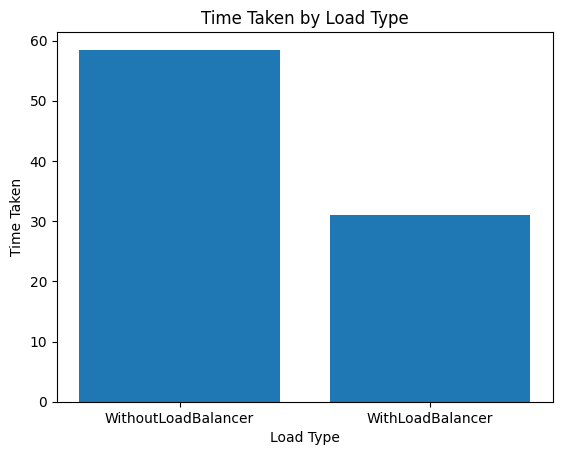

In [ ]:
data = pd.DataFrame({
    "load_type": ["Unoptimized", "Optimized"],
    "time_taken": [58, 31]
})

plt.bar(data['load_type'], data['time_taken'])
plt.xlabel('Load Type')
plt.ylabel('Time Taken')
plt.title('Latency improvement')
plt.show()